In [20]:
import numpy as np
import pandas as pd
import sklearn as sk

# Read files
train_data = pd.read_csv("train.csv")
test_df = pd.read_csv('test.csv')

In [21]:
# Drop unneeded columns
cols_to_drop = ['Cabin', 'Name', 'Ticket']
train_data = train_data.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)
train_data = train_data.drop("PassengerId", axis=1)

In [22]:

DataFrame = None
Columns = []
def PandasOneHotEncodeNumpy(DataFrame, Columns):
    OutNumpyMat = None
    columnNames = []
    
    for col in Columns:
        unique_values = sorted(DataFrame[col].unique())
        one_hot = (DataFrame[col].values[:, None] == unique_values).astype(int)
        one_hot = one_hot[:, :-1]
        
        if OutNumpyMat is None:
            OutNumpyMat = one_hot
        else:
            OutNumpyMat = np.hstack((OutNumpyMat, one_hot))
        
        columnNames.extend([f"{col}_{val}" for val in unique_values[:-1]])
    
    return OutNumpyMat, columnNames

In [23]:
# One hot encode using custom function
def one_hot_encode_sex_embarked(df):
    # Remove rows where Embarked is NaN
    df = df.dropna(subset=['Embarked'])
    
    # Use custom one-hot encoding function
    encoded_matrix, column_names = PandasOneHotEncodeNumpy(df, ['Sex', 'Embarked'])
    
    # Create DataFrame with encoded features
    encoded_df = pd.DataFrame(encoded_matrix, columns=column_names, index=df.index)
    
    # Drop original categorical columns and add encoded ones
    df_encoded = df.drop(columns=['Sex', 'Embarked'])
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    
    return df_encoded

In [24]:
# Fill missing ages with median age
def fill_missing_ages(df):
    median_age = df['Age'].median()
    df['Age'] = df['Age'].fillna(median_age)
    return df

In [25]:
# Normalize features
def normalize_features(df, minmax_cols, standard_cols, fit_stats=None):
    df_norm = df.copy()
    if fit_stats is None:
        fit_stats = {}
        for col in minmax_cols:
            fit_stats[col] = {
                'min': df_norm[col].min(),
                'max': df_norm[col].max()
            }
        for col in standard_cols:
            fit_stats[col] = {
                'mean': df_norm[col].mean(),
                'std': df_norm[col].std()
            }
    for col in minmax_cols:
        min_val = fit_stats[col]['min']
        max_val = fit_stats[col]['max']
        df_norm[col] = (df_norm[col] - min_val) / (max_val - min_val)
    for col in standard_cols:
        mean = fit_stats[col]['mean']
        std = fit_stats[col]['std']
        df_norm[col] = (df_norm[col] - mean) / std
    if fit_stats is not None:
        return df_norm, fit_stats
    else:
        return df_norm
    
# One hot encode and fill missing ages
train_data = one_hot_encode_sex_embarked(train_data)
test_df = one_hot_encode_sex_embarked(test_df)
train_data = fill_missing_ages(train_data)
test_df = fill_missing_ages(test_df)


# Normalize features
minmax_cols = ['Pclass','Fare','Age', 'SibSp', 'Parch']
standard_cols = []
fit_stats = {}
train_data, fit_stats = normalize_features(train_data, minmax_cols, standard_cols)
test_df, _ = normalize_features(test_df, minmax_cols, standard_cols, fit_stats)


In [26]:
# sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [27]:
# Initialize random params function

def initialize_params(n_features, seed=39):
    np.random.seed(seed)
    w = np.random.randn(n_features, 1) * 0.01
    b = 0.0
    return w, b


In [28]:
# Sigmoid
def forward(X, w, b):
    m_samples = X.shape[0]
    Z = np.dot(X, w) + b
    a = sigmoid(Z)
    return a

In [29]:
# Compute cost
# reg is a string that is either 'l1', 'l2', or None
def compute_cost(y, y_hat, w, reg_lambda, reg=None):
    m_samples = y.shape[0]
    epsilon = 1e-15
    cost = -(1 / m_samples) * np.sum((y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon)))
    if reg == 'l1':
        cost += reg_lambda * np.sum(np.abs(w))
    elif reg == 'l2':
        cost += (reg_lambda / 2) * np.sum(w ** 2)
    return cost

In [30]:
# Compute gradients
def compute_gradients(X, y, y_hat, w, reg_lambda=0.0, reg=None):

    m_samples = X.shape[0]
    if reg == 'l1':
        dw = (1 / m_samples) * np.dot(X.T, (y_hat - y)) + reg_lambda * np.sign(w) / m_samples
    elif reg == 'l2':
        dw = (1 / m_samples) * np.dot(X.T, (y_hat - y)) + reg_lambda * w / m_samples
    else:
        dw = (1 / m_samples) * np.dot(X.T, (y_hat - y))
    db = (1 / m_samples) * np.sum(y_hat - y)
    return dw, db

In [31]:
# Update params
def update_params(w, b, dw, db, lr):
    w -= lr * dw
    b -= lr * db
    return w, b


In [32]:
# Train function
def train(X, y, lr, n_epochs, X_val=None, y_val=None, reg_lambda=0.01, reg=None):
    m_samples, m_features = X.shape
    w, b = initialize_params(m_features, 35)
    train_costs = []
    val_costs = []

    for epoch in range(n_epochs):
        y_hat = forward(X, w, b)
        cost = compute_cost(y, y_hat, w, reg_lambda, reg)
        dw, db = compute_gradients(X, y, y_hat, w, reg_lambda=0.01, reg=reg)
        w, b = update_params(w, b, dw, db, lr)

        train_costs.append(cost)

        if X_val is not None and y_val is not None:
            y_val_hat = forward(X_val, w, b)
            val_cost = compute_cost(y_val, y_val_hat, w, reg_lambda, reg)
            val_costs.append(val_cost)

    return w, b, val_costs, train_costs


In [33]:
# Predict function
def predict_proba(X, w, b):
    return forward(X, w, b)


In [34]:


# Finish preparing data
# The categorical columns are already encoded using our custom function
X = train_data.drop("Survived", axis=1).values.astype(float)
y = train_data["Survived"].values.reshape(-1, 1).astype(float)

In [35]:
#Split data into training and validation sets
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

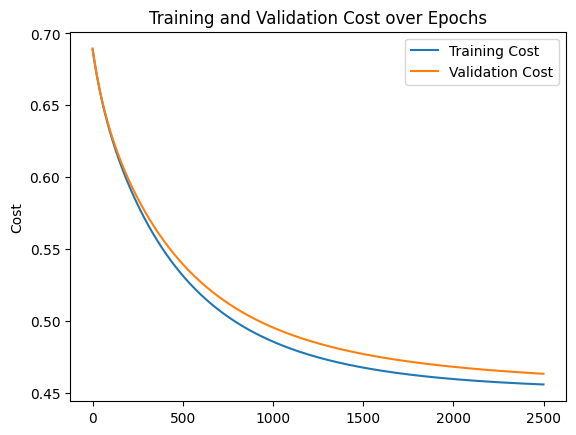

In [36]:

import matplotlib.pyplot as plt

# Train model and plot costs
w, b, train_costs, val_costs = train(X_train, y_train, lr=0.02, n_epochs=2500, X_val=X_val, y_val=y_val , reg_lambda=0.0001, reg='l2')

plt.plot(train_costs, label='Training Cost')
plt.plot(val_costs, label='Validation Cost')
plt.ylabel('Cost')
plt.title('Training and Validation Cost over Epochs')
plt.legend()
plt.show()

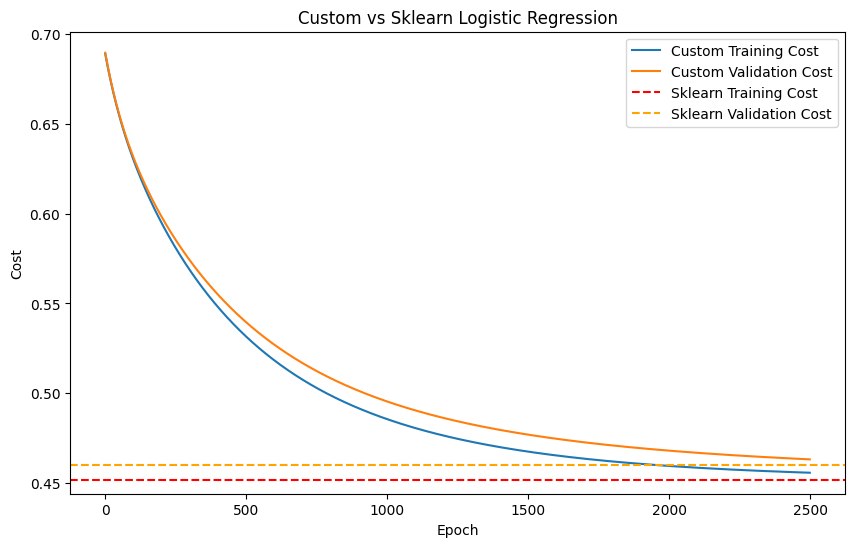

Final Custom Training Cost: 0.4558
Final Custom Validation Cost: 0.4633
sklearn Training Cost: 0.4516
sklearn Validation Cost: 0.4603


In [37]:
# SKL implementation.

from sklearn.linear_model import LogisticRegression

# Fit sklearn logistic regression

# Fit once with a high number of iterations
clf = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=10000)
clf.fit(X_train, y_train.ravel())

# Predict and compute cost once
y_train_pred = clf.predict_proba(X_train)[:, 1].reshape(-1, 1)
y_val_pred = clf.predict_proba(X_val)[:, 1].reshape(-1, 1)

train_cost = compute_cost(y_train, y_train_pred, clf.coef_.T, reg_lambda=0.001, reg='l2')
val_cost = compute_cost(y_val, y_val_pred, clf.coef_.T, reg_lambda=0.001, reg='l2')


# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(train_costs, label='Custom Training Cost')
plt.plot(val_costs, label='Custom Validation Cost')
# Add sklearn costs as horizontal reference lines
plt.axhline(y=train_cost, color='red', linestyle='--', label='Sklearn Training Cost')
plt.axhline(y=val_cost, color='orange', linestyle='--', label='Sklearn Validation Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Custom vs Sklearn Logistic Regression')
plt.legend()
plt.show()

# Print sklearn final costs for comparison
print(f"Final Custom Training Cost: {train_costs[-1]:.4f}")
print(f"Final Custom Validation Cost: {val_costs[-1]:.4f}")
print(f"sklearn Training Cost: {train_cost:.4f}")
print(f"sklearn Validation Cost: {val_cost:.4f}")

In [38]:

#drop the first column in X_test to match training data
X_test = test_df.drop("PassengerId", axis=1).values.astype(float)

# Make predictions on test set and save to CSV
y_test_pred_proba = predict_proba(X_test, w, b)
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': y_test_pred.flatten()})
output.to_csv('submission.csv', index=False)

